In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
#from torch.utils.tensorboard import SummaryWriter # TensorBoard support
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
import time
#from torchviz import make_dot
import torch.optim as optim
from collections import defaultdict
import pickle
import dill
import json
import datetime
from IPython.display import clear_output
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity
try:
    import google.colab
    from google.colab import files  
    COLAB = True
except:
    COLAB = False

In [6]:
#Como siempre chequeamos que este el GPU o el CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cpu


In [7]:
# Cargamos los datos de FASHION-MNIST
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [8]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    
    
    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)
    
    self.dropout = nn.Dropout(p=0.3)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.leaky_relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.leaky_relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = self.dropout(t)
    t = F.leaky_relu(t)

    # fc2
    t = self.fc2(t)
    t = self.dropout(t)
    t = F.leaky_relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [9]:
model = Network().to(device)
print(model)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [10]:
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Imprimimos el progreso...
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")

# De manera similar, definimos la función de testeo
def test_loop(dataloader,model,loss_fn):
    num_samples  = 0
    num_batches  = 0
    avrg_loss    = 0
    frac_correct = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.    
    model = model.to(device)    
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device)
            y = y.to(device)           
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            num_batches += 1
            avrg_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            num_samples += y.size(0)            
            frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [11]:
# Definimos hiperparámetros de entrenamiento
learning_rate = 1e-3
batch_size = 1000
num_epochs = 50
#num_k = 1 #72
#n=10 # Recordar que 28*28=784

optim1 = torch.optim.SGD#(model.parameters(),lr=learning_rate)
optim2 = torch.optim.Adam#(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
optimizers = [optim1,optim2]
# Creamos una funcion de perdida
loss_fn = nn.CrossEntropyLoss()
# Creamos un DataFrame de pandas para ir almacenando los valores calculados.
df = pd.DataFrame()
# Simulamos por tramos porque google colab se desconecta antes de que concluya para todos los valores de n en la lista.
for optim in optimizers:
#for k in range(num_k):
    # Creamos el modelo y el optimizador
    model = Network()
    # Creamos los dataloaders ...
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    # ... en particular, usamos el dataset de prueba (test) como dataset de validación
    valid_dataloader = DataLoader(test_dataset,batch_size=batch_size)  
    
    optimizer = optim(model.parameters(),lr=learning_rate)
    # Entrenamos el modelo y calcualmos curvas.
    min_valid_loss = float("inf")
    for epoch in range(num_epochs):
        train_loop(train_dataloader,model,loss_fn,optimizer)
        train_loss,train_accu = test_loop(train_dataloader,model,loss_fn)
        valid_loss,valid_accu = test_loop(valid_dataloader,model,loss_fn)
        print(f"optimizer={str(optim)} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
        df = df.append({"optimizer":str(optim),
                        "epoch":epoch,
                        "train_loss":train_loss,
                        "train_accu":train_accu,
                        "valid_loss":valid_loss,
                        "valid_accu":valid_accu}
                        ,ignore_index=True)
json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
df.to_json(json_fname)
if COLAB:
    files.download(json_fname)

optimizer=<class 'torch.optim.sgd.SGD'> epoch=0 train_loss=2.3046668569246926 train_accu=0.0566 valid_loss=2.3047264575958253 valid_accu=0.0585
optimizer=<class 'torch.optim.sgd.SGD'> epoch=1 train_loss=2.304546586672465 train_accu=0.05615 valid_loss=2.3046074390411375 valid_accu=0.0577
optimizer=<class 'torch.optim.sgd.SGD'> epoch=2 train_loss=2.3044262528419495 train_accu=0.055516666666666666 valid_loss=2.3044883251190185 valid_accu=0.0573
optimizer=<class 'torch.optim.sgd.SGD'> epoch=3 train_loss=2.3043066541353863 train_accu=0.055216666666666664 valid_loss=2.304369878768921 valid_accu=0.0569
optimizer=<class 'torch.optim.sgd.SGD'> epoch=4 train_loss=2.3041882872581483 train_accu=0.054983333333333335 valid_loss=2.3042528867721557 valid_accu=0.0566
optimizer=<class 'torch.optim.sgd.SGD'> epoch=5 train_loss=2.3040709495544434 train_accu=0.0545 valid_loss=2.3041372776031492 valid_accu=0.0569
optimizer=<class 'torch.optim.sgd.SGD'> epoch=6 train_loss=2.3039552013079327 train_accu=0.0544

In [12]:
df2 = df.pivot_table(index=["optimizer","epoch"],aggfunc="count").reset_index()
#df2

In [13]:
df3 = df.pivot_table(index=["optimizer","epoch"],aggfunc="mean").reset_index()
#df3

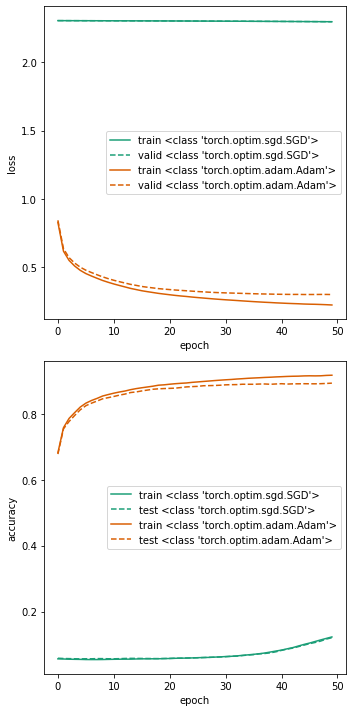

In [14]:
fig,axes=plt.subplots(2,1)
fig.set_size_inches(5.0,10.0)
colors = cm.Dark2.colors
for color,optimizer in zip(colors,df["optimizer"].unique()):
    dfn = df3[df3["optimizer"]==optimizer]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,dfn["train_loss"],label=f"train {optimizer}",color=color)
    ax.plot(x,dfn["valid_loss"],label=f"valid {optimizer}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x,dfn["train_accu"],label=f"train {optimizer}",color=color)
    ax.plot(x,dfn["valid_accu"],label=f"test {optimizer}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.savefig("dif_optimizers.pdf")
plt.show()   

El mejor optimizador es Adam